In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
from utils.data_utils import load_frametime,load_fuseddata
from utils.coord_utils import linear_interpolation,CSI
from utils.coord_utils import computeVelocity,computeAcceleration
from math import *
import colorsys

# 计算绝对坐标

In [6]:
# 导入相对坐标轨迹
with open("result/tracking_result_w.json","r") as f:
    tracks_json = json.load(f)
    
# track_id = 429 #要查看的track的ID
# track = tracks_json[track_id]

# 导入拍摄时间
frame_time = load_frametime("/media/yxhuang/database/binocular_video/20191022_022500_time.txt")
# 导入融合数据
fused_data = load_fuseddata("/media/yxhuang/database/binocular_video/fused_pose_planePoint_1022_022500.txt")

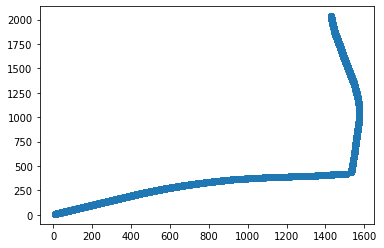

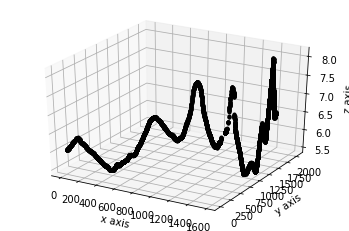

In [3]:
X = np.array(fused_data["x"])-1195450
Y = np.array(fused_data["y"])-3376830
Z = np.array(fused_data["z"])
plt.figure()
plt.scatter(X,Y)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(X,Y,Z,'k.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
# ax.view_init(elev=135, azim=90)
plt.show()

In [4]:
tracks = []
for track_id in range(len(tracks_json)):
    track = tracks_json[track_id]
    m = len(track["frames"])

    track["XYZ_w"] = []
    track["time"] = []

    for i in range(m):
        frame = track["frames"][i]
        time = frame_time[frame-1]
        track["time"].append(time)

        # 线性内插
        inter_data = linear_interpolation(fused_data,time)

        tx = inter_data["x"];ty = inter_data["y"];tz = inter_data["z"];
        t = np.array([tx,ty,tz]).reshape(3,1)

        r = inter_data["roll"];p = inter_data["pitch"];y = inter_data["yaw"]-3*pi/2;
        Rr = np.array([[1, 0,       0],
                       [0, cos(r), -sin(r)],
                       [0, sin(r),  cos(r)]]).reshape(3,3)
        Rp = np.array([[cos(p), 0, sin(p)],
                       [0,      1, 0     ],
                       [-sin(p),0, cos(p)]]).reshape(3,3)
        Ry = np.array([[cos(y), -sin(y), 0],
                       [sin(y),  cos(y), 0],
                       [0,       0,      1]]).reshape(3,3)

        R = Rr@Rp@Ry
        XYZ = np.array([track["XYZs"][2][i],-track["XYZs"][0][i],-track["XYZs"][1][i]]).reshape(3,1)
        XYZ /= 10# dm->m
        XYZ_w = R@XYZ+t

#         if i == 0:
#             print(XYZ)
#             print(XYZ_w)
#             print(np.linalg.norm(np.array(XYZ)))
#             print(np.linalg.norm(np.array(XYZ_w)))
        XYZ_w = XYZ_w.tolist()
        track["XYZ_w"].append(XYZ_w)
    tracks.append(track)

KeyboardInterrupt: 

# 导出新的绝对轨迹

In [ ]:
# output_path = "result/tracking_result_w.json"
# # output_path = "result/tracking_result_w.json"
# with open(output_path,"w") as f:
#     json.dump(tracks,f)

# 绘制轨迹

In [7]:
# 导入轨迹
with open("result/tracking_result_w.json","r") as f:
    tracks = json.load(f)
# 类型名
with open("yolo3_deepsort/model_data/classes_name.txt") as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]
# 生成每种类型对应的颜色
hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
idx_color = {}
for i,cat in enumerate(class_names):
    idx_color[cat] = int(i)

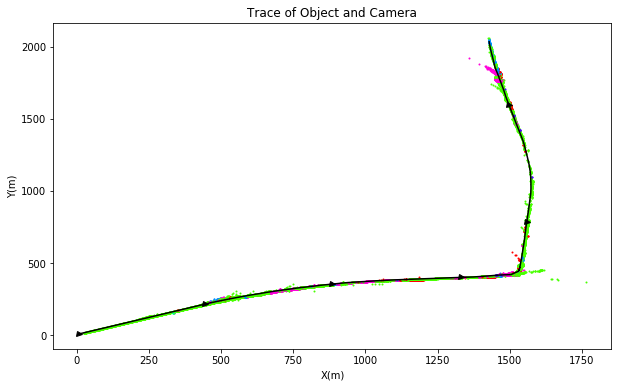

In [8]:
scalex = 1195450
scaley = 3376830
X = np.array(fused_data["x"])-scalex
Y = np.array(fused_data["y"])-scaley
Z = np.array(fused_data["z"])
plt.figure(figsize=(10,6))
plt.plot(X,Y,color=(0,0,0),ls="-",marker=">",label="camera",markersize=5,markevery=0.2)#车辆自身轨迹

# 绘制目标轨迹
for track in tracks:
    XYZ_w = np.squeeze(np.array(track["XYZ_w"]))
    if len(XYZ_w) != 0:
        XYZ_w = XYZ_w.reshape(XYZ_w.size//3,3)
#         print(XYZ_w)
        X_w = XYZ_w[:,0]-scalex
        Y_w = XYZ_w[:,1]-scaley
        plt.scatter(X_w,Y_w,s=1,color=colors[idx_color[track["category"]]])
plt.title("Trace of Object and Camera")
plt.xlabel("X(m)")
plt.ylabel("Y(m)")
plt.show()

# 计算曲率

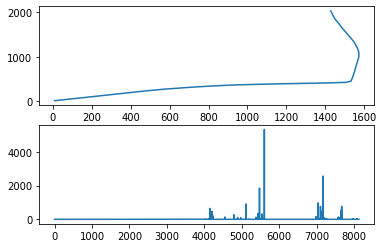

In [9]:
X = np.array(fused_data["x"])-1195450
Y = np.array(fused_data["y"])-3376830
Z = np.array(fused_data["z"])
# X = np.array(fused_data["x"])
# Y = np.array(fused_data["y"])
# X = np.array(range(15))/7.5-1
# Y = np.sqrt(1-X**2)
cur = CSI(X,Y)
plt.subplot(211)
plt.plot(X,Y)
plt.subplot(212)
plt.plot(range(len(X)),cur)

In [12]:
fps = 30
T = np.array(fused_data["time"])/1000
# dT = np.diff(dT,n=1)
vx,vy,vz,v = computeVelocity(X,Y,Z,T)
ax,ay,az,a = computeAcceleration(X,Y,Z,T)

In [11]:
def print_kw(a,kwargs):
    print(a)
    for k,w in kwargs.items():
        print("%s : %s" % (k,w))

In [ ]:
_dict_ = {"a":1,"b":2}
print_kw("test",_dict_)